# Animation of the PSF of interferometers

_M Kenworthy_ Leiden Observatory kenworthy@strw.leidenuniv.nl

Based on hcipy tutorials https://docs.hcipy.org/0.3.1/tutorials/index.html and examples, and http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/


In [1]:
#pip install progressbar2

In [2]:
#pip install ffpmeg

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from hcipy import *
from scenes import *

from progressbar import progressbar 

anim_version='v1'

In [4]:

# These modules are used for animating some of the graphs in our notebook.
from matplotlib import animation, rc
#from IPython.display import HTML


## HCIpy setup

In [6]:
pupil_grid = make_pupil_grid(256, 1.5)
focal_grid = make_focal_grid(8, 12)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

In [7]:
aperture = circular_aperture?

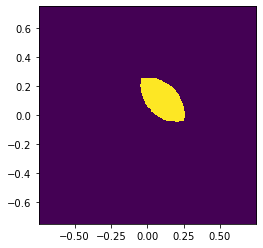

In [15]:
aperture1 = circular_aperture(0.5,(0.2,0.2))
aperture2 = circular_aperture(0.5)

f1 = aperture1(pupil_grid) * aperture2(pupil_grid)

imshow_field(f1)


In [ ]:

aperture = make_obstructed_circular_aperture(0.8, 0.10, 2, 0.01)
angle = 20 * np.pi / 180 # radians
supersampling = 4

supersampled_pupil_grid = make_supersampled_grid(pupil_grid, supersampling)

sdf = Field(aperture(supersampled_pupil_grid.rotated(-angle)), supersampled_pupil_grid)

telescope_pupil = subsample_field(sdf, supersampling)

fig, (a1, a2) = plt.subplots(1,2,figsize=(8,4))
imshow_field(telescope_pupil, cmap='gray', ax=a1)
a1.set_title('Aperture')
a2.set_title('PSF')

wf = Wavefront(telescope_pupil)
im1 = focal_image = prop(wf).intensity
im2 = imshow_field(np.log10(focal_image / focal_image.max()), vmin=-5, cmap='inferno', ax=a2)


plt.show()


In [ ]:

pupil_diameter = Stage()
pupil_diameter.add(Act(0.5, 1.0, 2,  'sig',10))
pupil_diameter.add(Act(1.0, 1.0, 14, 'sig',10))
pupil_diameter.add(Act(1.0, 0.5, 2,  'sig',10))
print(pupil_diameter.total_time())

angle = Stage()
angle.add(Act(0.0, 0.0,  9,'sig',10))
angle.add(Act(0.0, 180., 1,'sig',10))
angle.add(Act(180, 0, 1 ,'sig',10))
angle.add(Act(0, 0.0, 3,'sig',10))
angle.add(Act(0.0, 90., 1,'sig',10))
angle.add(Act(90, 0, 1 ,'sig',10))
angle.add(Act(0, 0.0, 1,'sig',10))
angle.add(Act(0.0, 0.0,  1,'sig',10))
print(angle.total_time())

wids = Stage()
wids.add(Act(0.0, 0.0, 5, 'sig', 10))
wids.add(Act(0.0, 0.1, 2, 'sig', 10))
wids.add(Act(0.1, 0.1, 1, 'sig', 10))
wids.add(Act(0.1, 0.05, 2, 'sig', 10))
#wids.add(Act(0.1, 0.1, 6, 'sig', 10))

wids.add(Act(0.05, 0.05, 2.5, 'sig', 10))
wids.add(Act(0.05, 0.0, 0.50, 'sig', 10))
wids.add(Act(0.0, 0.05, 0.50, 'sig', 10))
wids.add(Act(0.05, 0.05, 2.5, 'sig', 10))


wids.add(Act(0.05, 0.0, 1, 'sig', 10))
wids.add(Act(0.0, 0.0, 1, 'sig', 10))
print(wids.total_time())
seco = Stage()
seco.add(Act(0.0, 0.0, 2, 'sig', 10))
seco.add(Act(0.0, 0.7, 2, 'sig', 10))
seco.add(Act(0.7, 0.3, 1, 'sig', 10))
seco.add(Act(0.3, 0.3, 11, 'sig', 10))
seco.add(Act(0.3, 0.0, 2, 'sig', 10))
print(seco.total_time())

nspines = Stage()

nspines.add(Act(2., 2., 13.0))
nspines.add(Act(4., 4., 5.0))

t = np.arange(0,pupil_diameter.total_time(),0.05)

plt.plot(t, pupil_diameter.t(t))
plt.plot(t, angle.t(t)/180.)
plt.plot(t, wids.t(t))
plt.plot(t, seco.t(t))
plt.plot(t, nspines.t(t)/6)

In [ ]:
total_time_animation = pupil_diameter.total_time() # seconds
frame_rate = 10          # frames per second
total_frames = total_time_animation * frame_rate # seconds
supersampling = 4

plt.figure(figsize=(8,4))

anim = FFMpegWriter('video.mp4', framerate=frame_rate)

times = np.arange(0,total_time_animation, 1./frame_rate)

pd = pupil_diameter.t(times)
an = angle.t(times)
wi = wids.t(times)
se = seco.t(times)
ns = (nspines.t(times)).astype(int)
for t in progressbar(range(np.int(total_frames))):
    aperture = make_obstructed_circular_aperture(pd[t], se[t], ns[t], wi[t])
    ang = an[t] * np.pi / 180 # radians

    supersampled_pupil_grid = make_supersampled_grid(pupil_grid, supersampling)

    sdf = Field(aperture(supersampled_pupil_grid.rotated(-ang)), supersampled_pupil_grid)

    telescope_pupil = subsample_field(sdf, supersampling)

    plt.clf()
#    plt.suptitle('Timestep %d / %d' % (t, total_frames))
    
    plt.subplot(1,2,1)
    imshow_field(telescope_pupil, cmap='gray')
    plt.title('Aperture')
    
    plt.text(0.05,0.05,anim_version, fontsize=12, color='white',
            horizontalalignment='left', verticalalignment='bottom',
            transform=plt.gca().transAxes)
    


    wf = Wavefront(telescope_pupil)
    focal_image = prop(wf).intensity
    
    plt.subplot(1,2,2)
    imshow_field(np.log10(focal_image / focal_image.max()), vmin=-5, cmap='inferno')
    #plt.title('frame {} at time {:.2f}'.format(timestep, timestep/frame_rate))
    plt.title('PSF')

    plt.text(0.95,0.05,"@mattkenworthy", fontsize=12, color='white',
        horizontalalignment='right', verticalalignment='bottom',
        transform=plt.gca().transAxes)


    
    
    anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim
    


In [ ]:
# ffmpeg -i video.mp4 -vf "fps=10,scale=400:-1:flags=lanczos" -c:v pam -f image2pipe - | convert -delay 10 - -loop 0 -layers optimize output.gif